In [35]:
import numpy as np
import pandas as pd
from custom_ml_utils import (
    data_splitting,
    encoders,
    metrics,
    pca,
    scalers,
    visualizations,
)

In [36]:
# Download the dataset
!kaggle datasets download -d fedesoriano/heart-failure-prediction

# Unzip the dataset
!unzip -o heart-failure-prediction.zip


Dataset URL: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction
License(s): ODbL-1.0
heart-failure-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  heart-failure-prediction.zip
  inflating: heart.csv               


In [37]:
random_seed = 42
np.random.seed(random_seed)

In [38]:
# Load the dataset
data = pd.read_csv('heart.csv')

# Show the first few rows
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [39]:
X = data.drop('HeartDisease', axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
dtypes: float64(1), int64(5), object(5)
memory usage: 79.0+ KB


In [40]:
def encode_data(X):
    # columns to be one-hot encoded
    one_hot_columns = ["ChestPainType", "RestingECG", "ST_Slope"]

    # columns to be ordinal encoded
    ordinal_columns = ["Sex", "ExerciseAngina"]

    # apply one-hot encoding
    one_hot_encoder = encoders.OneHotEncoder()
    for column in one_hot_columns:
        x = one_hot_encoder.fit_transform(X[column], column_prefix=column)
        # drop the original column
        X = X.drop(column, axis=1)
        # add the new columns
        X = pd.concat([X, x], axis=1)

    # apply ordinal encoding
    ordinal_encoder = encoders.OrdinalEncoder()
    for column in ordinal_columns:
        x = ordinal_encoder.fit_transform(X[column], column_prefix=column)
        # drop the original column
        X = X.drop(column, axis=1)
        # add the new columns
        X = pd.concat([X, x], axis=1)

    return X

In [41]:
def preprocess_data(data, train=True) -> tuple:
    """
    Preprocess the data

    Args:
    data: pd.DataFrame: the data to preprocess
    train: bool: whether the data is the training set

    Returns:
    X: np.ndarray: the preprocessed data
    y: np.ndarray: the target
    """
    if train:
        # Get the features and the target
        X = data.drop('HeartDisease', axis=1)
        y = data['HeartDisease']
        
    X = encode_data(X)
    y = y

    # columns to be min-max scaled
    columns_to_scale = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]
    # getting their indices
    indices = [X.columns.get_loc(column) for column in columns_to_scale]

    #  convert the data to a numpy array
    X = X.to_numpy()
    y = y.to_numpy()

    # apply min-max scaling
    scaler = scalers.MinMaxScaler()
    X = scaler.fit_transform(X, indices)

    # return the preprocessed data
    return X, y


In [42]:
X, y = preprocess_data(data)

In [43]:
X

array([[0.24489796, 0.7       , 0.47927032, ..., 1.        , 1.        ,
        0.        ],
       [0.42857143, 0.8       , 0.29850746, ..., 0.        , 0.        ,
        0.        ],
       [0.18367347, 0.65      , 0.46932007, ..., 1.        , 1.        ,
        0.        ],
       ...,
       [0.59183673, 0.65      , 0.2172471 , ..., 0.        , 1.        ,
        1.        ],
       [0.59183673, 0.65      , 0.39137645, ..., 0.        , 0.        ,
        0.        ],
       [0.20408163, 0.69      , 0.29021559, ..., 1.        , 1.        ,
        0.        ]])

In [44]:
# KNN model definition
class KNN:
    """
    K-Nearest Neighbors classifier.

    Parameters:
    -----------
    k: int
        The number of closest neighbors that will determine the class of the sample that we wish to predict.
    """

    def __init__(self, k=5):
        """
        Initialize the KNN classifier.

        Parameters:
        -----------
        k: int
            The number of closest neighbors that will determine the class of the sample that we wish to predict
        """
        self.k = k

    def fit(self, X, y):
        """
        Fit the training data to the model.

        Parameters:
        -----------
        X: numpy array
            The training data
        y: numpy array
            The target labels
        """
        self.X = X
        self.y = y

    def predict(self, X):
        """
        Predict the class labels for the provided data.

        Parameters:
        -----------
        X: numpy array
            The data to predict the class labels for

        Returns:
        --------
        numpy array
            The predicted class labels
        """
        neighbors = self.get_neighbors(X)
        return self.get_majority(neighbors)
    
    def get_neighbors(self, X):
        """
        Get the indices of the k closest neighbors for each test instance.

        Parameters:
        -----------
        X: numpy array
            The data to find the closest neighbors for

        Returns:
        --------
        numpy array
            The indices of the k closest neighbors for each test instance
        """
        distances = self.get_distances(X)
        neighbors = np.argsort(distances, axis=1)[:, :self.k]
        return neighbors
    
    def __euclidean_distance(self, x1, x2):
        """
        Compute the Euclidean distance between two vectors.

        Parameters:
        -----------
        x1: numpy array
            The first vector

        x2: numpy array
            The second vector

        Returns:
        --------
        float
            The Euclidean distance between the two vectors
        """
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    
    # def get_distances(self, X):
    #     """
    #     Get the distances between each test instance and all training instances.

    #     Parameters:
    #     -----------
    #     X: numpy array
    #         The data to find the distances for

    #     Returns:
    #     --------
    #     numpy array
    #         The distances between each test instance and all training instances
    #     """
    #     distances = np.zeros((X.shape[0], self.X.shape[0]))
    #     for i, test_instance in enumerate(X):
    #         for j, train_instance in enumerate(self.X):
    #             distances[i, j] = self.__euclidean_distance(test_instance, train_instance)
    #     return  distances
    
    def get_distances(self, X):
        # Step 1: Compute the squared norms of each row in a and b
        X_norm_squared = np.sum(X**2, axis=1).reshape(-1, 1)  # shape (n_test, 1)
        selfX_norm_squared = np.sum(self.X**2, axis=1).reshape(1, -1)  # shape (1, n_train)

        # Step 2: Compute the dot product between a and b
        dot_product = np.dot(X, self.X.T)  # shape (n_test, n_train)

        # Step 3: Compute the pairwise squared Euclidean distances
        distances_squared = X_norm_squared + selfX_norm_squared - 2 * dot_product

        # Step 4: Take the square root to get the Euclidean distances
        distances = np.sqrt(distances_squared)
    
        return distances
    
    def get_majority(self, neighbors):
        """
        Get the majority class label for each test instance.

        Parameters:
        -----------
        neighbors: numpy array
            The indices of the k closest neighbors for each test instance

        Returns:
        --------
        numpy array
            The majority class label for each test instance
        """
        majority = np.zeros(neighbors.shape[0], dtype=int)
        for i, row in enumerate(neighbors):
            majority[i] = np.argmax(np.bincount(self.y[row]))
        return majority
    
    def score(self, X, y):
        """
        Compute the accuracy of the model.

        Parameters:
        -----------
        X: numpy array
            The test data
        y: numpy array
            The true class labels

        Returns:
        --------
        float
            The accuracy of the model
        """
        y_pred = self.predict(X)
        return np.mean(y == y_pred)

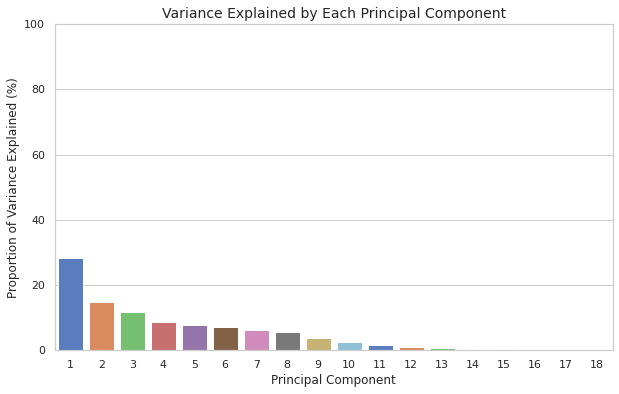

In [45]:
# apply PCA
pca = pca.PCA()
pca.fit(X)
pca.plot_explained_variance()

In [46]:
# split the data
X_train, X_test, y_train, y_test = data_splitting.train_test_split(X, y, test_size=0.2, random_seed=random_seed)

In [47]:
# apply KNN
knn = KNN(k=5)
knn.fit(X_train, y_train)

In [48]:
# get the accuracy
accuracy = knn.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8306010928961749


In [49]:
# perform cross-validation
data_splitting.cross_val_score(knn, X, y, cv=5)

array([0.83606557, 0.8579235 , 0.8579235 , 0.83060109, 0.82513661])

In [50]:
# try sklearn's KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

# fit the model
knn.fit(X_train, y_train)

# get the accuracy
accuracy = knn.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8306010928961749


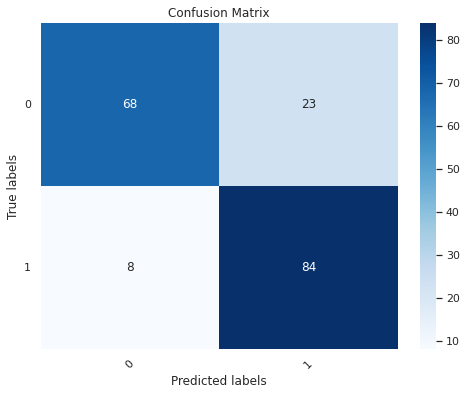

In [51]:
# plot the confusion matrix
conf_matrix = metrics.confusion_matrix(y_test, knn.predict(X_test))
visualizations.plot_confusion_matrix(conf_matrix, labels=[0, 1])